In [1]:
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt
from time import time
from tqdm import tqdm
from scipy.linalg import khatri_rao
import pdb

In [2]:
'''Load separable data'''
train_separable = sio.loadmat("../data/svm data/separable_case/train_separable.mat")
test_separable = sio.loadmat("../data/svm data/separable_case/test_separable.mat")

'''Load overlap data'''
train_overlap = sio.loadmat("../data/svm data/overlap_case/train_overlap.mat")
test_overlap = sio.loadmat("../data/svm data/overlap_case/test_overlap.mat")

In [3]:
is_separated_data = False

In [4]:
if is_separated_data:
        train_data, test_data = train_separable, test_separable
else:
    train_data, test_data = train_overlap, test_overlap

A, B = train_data['A'], train_data['B']
train_labels = np.concatenate([np.ones(A.shape[1]), np.zeros(B.shape[1])], axis=0)
test_X, test_labels = test_data['X_test'], test_data['true_labels'].flatten()

test_labels = np.where(test_labels==1, 1, 0)

d, A_n = A.shape
B_n = B.shape[1]
test_n = test_X.shape[1]

In [5]:
train_data = np.block([[A,B],[train_labels]])
test_data = np.block([[test_X],[test_labels]])
d, train_num, test_num = train_data.shape[0]-1, train_data.shape[1], test_data.shape[1]

## Model

In [20]:
class Linear:
    def __init__(self, input_size, output_size, activation='relu') -> None:
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation

        np.random.seed(1000)
        self.W = np.random.randn(input_size, output_size)
        self.b = np.random.randn(1,output_size)

        assert activation in ["relu", "sigmoid"], f"Unknown activation Type passed: {activation}"
        self.activation = activation
        self.activation_fn = lambda x: np.maximum(x,0) if self.activation == 'relu' else 1/(1+np.exp(-np.clip(x,-30,30)))

        self.m = 0
        self.X = 0
        self.Y = None
        self.out = None
        self.grad_W = None
        self.grad_b = None

    def forward(self, X):
        self.m = X.shape[1]
        self.X = X
        self.Y = self.W.T@self.X+self.b.T
        self.out = self.activation_fn(self.Y)
        return self.out
    
    def get_agumented_X(self):
        return np.concatenate([self.X,np.ones((1,self.m))], axis=0)

    
    def backward(self, back_grad):
        # print(f"back grad shape: {back_grad.shape}")
        if self.activation == 'relu':
            self.G = np.where(self.out>=0, 1, 0)*back_grad
        else:
            self.G = self.activation_fn(self.Y)*(1-self.activation_fn(self.Y))*back_grad
        # pdb.set_trace()
        grad = (1/self.m)*self.get_agumented_X()@(self.G.T)
        grad_W_val = grad[:-1,:]
        grad_b_val = grad[-1:,:]
        if self.grad_W is None or self.grad_b is None:
            self.grad_W = grad_W_val
            self.grad_b = grad_b_val
        else:
            self.grad_W += grad_W_val
            self.grad_b += grad_b_val
        
        # print(self.W.shape, self.G.shape)
        return (1/self.m)*self.W@back_grad
    
    def clear_gradient(self):
        self.grad_W = None
        self.grad_b = None
    
    def first_order_update(self, lr):
        # print(lr)
        # print(self.W.shape, self.grad_W.shape)
        # print(self.b.shape, self.grad_b.shape)
        self.W -= lr*self.grad_W
        self.b -= lr*self.grad_b
        self.clear_gradient()
    
    def get_jacobian(self):
        return khatri_rao(self.get_agumented_X(), self.G).T
    
    def get_all_params(self):
        return np.concatenate([self.W.flatten(), self.b.flatten()], axis=0)
    
    def get_all_grads(self):
        return np.concatenate([self.grad_W.flatten(), self.grad_b.flatten()], axis=0)
    
    def get_params_num(self):
        return len(self.W.flatten())+len(self.b.flatten())
    
    def set_params(self, params):
        # print(np.linalg.norm(params-self.get_all_params()))
        W_param_num = len(self.W.flatten())
        self.W = params[:W_param_num].reshape(self.W.shape)
        self.b = params[W_param_num:].reshape(self.b.shape)

    
    # def update_using_approx_FIM(self, lr, flattened_J):
    #     J_W = flattened_J[:self.input_size*self.output_size].reshape(self.W.shape)
    #     J_b = flattened_J[self.input_size*self.output_size:].reshape(self.b.shape)




In [21]:
class Model:
    def __init__(self, node_nums, activations):
        self.layers = []
        for i in range(len(activations)):
            self.layers.append(Linear(node_nums[i], node_nums[i+1], activations[i]))
    
    def forward(self, X):
        self.m = X.shape[1]
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, back_grad):
        for layer in self.layers[::-1]:
            back_grad = layer.backward(back_grad)
    
    def clear_gradient(self):
        for layer in self.layers:
            layer.clear_gradient()
    
    def update(self, lr, degree="first_order", alpha=1e-3, max_FIM_det=100):
        if degree == 'first_order':
            for layer in self.layers:
                layer.first_order_update(lr)
        elif degree == 'natural_gradient':
            J = np.concatenate([layer.get_jacobian()for layer in self.layers], axis=1)
            self.F = (1/self.m)*J.T@J
            F_ = self.F+alpha*np.eye(self.F.shape[0])
            self.FIM = np.linalg.inv(F_)

            '''Normalize FIM if the determinant is too high'''
            det = np.linalg.det(self.FIM)
            if det > max_FIM_det:
                self.FIM *= max_FIM_det/det

            all_params = np.concatenate([layer.get_all_params() for layer in self.layers], axis=0)
            all_grads = np.concatenate([layer.get_all_grads() for layer in self.layers], axis=0)
            param_nums = [layer.get_params_num() for layer in self.layers]

            all_params -= lr* self.FIM@all_grads

            '''Set new param numbers in layers'''
            initial_param_idx = 0
            for i, layer in enumerate(self.layers):
                layer.set_params(all_params[initial_param_idx: initial_param_idx+param_nums[i]])
                initial_param_idx += param_nums[i]
                layer.clear_gradient()
            return np.linalg.det(self.FIM)
        

In [22]:
class BinaryCrossEntropy:
    def __init__(self) -> None:
        self.out = None
        self.back = None


    def compute(self, y_pred, y_labels):
        self.out =  np.mean(np.where(y_labels==0, -np.log2(np.clip(1-y_pred,1e-6, 1-1e-6)), -np.log2(np.clip(y_pred,1e-6, 1-1e-6))))
        self.back = np.where(y_labels==0, 1/(1-y_pred + 1e-6), -1/(y_pred+1e-6) )
        return self.out

    def backward(self):
        return self.back

In [23]:
def train(update_type="first_order", lr=1e-4, epochs = 10000, mini_batch_size = 32):
    model = Model([d, 1],['sigmoid'])
    loss = BinaryCrossEntropy()
    
    pbar = tqdm(list(range(1,epochs+1)))
    iteration = 0

    train_features, train_labels = train_data[:d], train_data[d:]
    test_features, test_labels = test_data[:d], test_data[d:]

    # train_features[0] /= 10000
    # test_features[0]/=10000
    
    validation_accuracy = 0
    average_loss = float("inf")
    val_loss = float("inf")

    train_info = {'iter_wise': {'iterations': [], 'loss': []}, 'epoch_wise': {'epochs': [], 'loss': [], 'val_loss': [], 'val_accuracy': []}}

    '''Log Initial epoch wise train info'''
    initial_train_pred, initial_test_pred = model.forward(train_features), model.forward(test_features)
    train_info['epoch_wise']['epochs'].append(0)
    train_info['epoch_wise']['loss'].append(loss.compute(initial_train_pred, train_labels))
    train_info['epoch_wise']['val_loss'].append(loss.compute(initial_test_pred, test_labels))
    train_info['epoch_wise']['val_accuracy'].append(np.mean(np.where(initial_test_pred>0.5,1,0)==test_labels))

    for epoch in pbar:
        data_idxs = set(range(train_num))
        epoch_loss_lst= []
        while data_idxs:
            iteration += 1
            sample_idx = np.random.choice(list(data_idxs),size=min(mini_batch_size, len(data_idxs)), replace=False).tolist()
            data_idxs -= set(sample_idx)
            data, labels = train_features[:, sample_idx], train_labels[:,sample_idx]
            out = model.forward(data)
            loss_val = loss.compute(out, labels)
            epoch_loss_lst.append(loss_val)
            loss_grad = loss.backward()
            model.backward(loss_grad)
            res = model.update(lr, update_type, alpha=1e-16, max_FIM_det=1000)
            # if res is not None:
            #     print(res)

            '''Log iter wise train info'''
            train_info['iter_wise']['iterations'].append(iteration)
            train_info['iter_wise']['loss'].append(loss_val)

        pbar.set_description("Iteration: %d Epoch: %d Loss: %f Epoch Loss: %f Val Loss: %f Validation Accuracy %f"%(iteration, epoch, round(loss_val,6), round(average_loss,6), round(val_loss,6), round(validation_accuracy,6)))
        # pdb.set_trace()
        pred_prob = model.forward(test_features)
        preds = np.where( pred_prob > 0.5, 1, 0)
        val_loss = loss.compute(pred_prob, test_labels)
        validation_accuracy = np.mean(test_labels == preds)
        average_loss = np.mean(epoch_loss_lst)

        '''Log epoch wise train info'''
        train_info['epoch_wise']['epochs'].append(epoch)
        train_info['epoch_wise']['loss'].append(average_loss)
        train_info['epoch_wise']['val_loss'].append(val_loss)
        train_info['epoch_wise']['val_accuracy'].append(validation_accuracy)
    
    return train_info



In [24]:
grad_descent_train_info = train("first_order", lr=1e-3, epochs=1000, mini_batch_size=32)

Iteration: 7000 Epoch: 1000 Loss: 0.247296 Epoch Loss: 0.302329 Val Loss: 0.142175 Validation Accuracy 0.985000: 100%|██████████| 1000/1000 [00:02<00:00, 499.45it/s]


In [25]:
natural_grad_descent_train_info = train("natural_gradient", lr=1e-3, epochs=1000, mini_batch_size=32)

Iteration: 7000 Epoch: 1000 Loss: 0.186069 Epoch Loss: 0.263271 Val Loss: 0.082599 Validation Accuracy 0.985000: 100%|██████████| 1000/1000 [00:03<00:00, 275.94it/s]


In [26]:
[(key, val[0]) for key, val in grad_descent_train_info['epoch_wise'].items()], [(key, val[0]) for key, val in natural_grad_descent_train_info['epoch_wise'].items()]

([('epochs', 0),
  ('loss', 0.7558308561990782),
  ('val_loss', 0.6793068999908947),
  ('val_accuracy', 0.8)],
 [('epochs', 0),
  ('loss', 0.7558308561990782),
  ('val_loss', 0.6793068999908947),
  ('val_accuracy', 0.8)])

## Plot train metrics

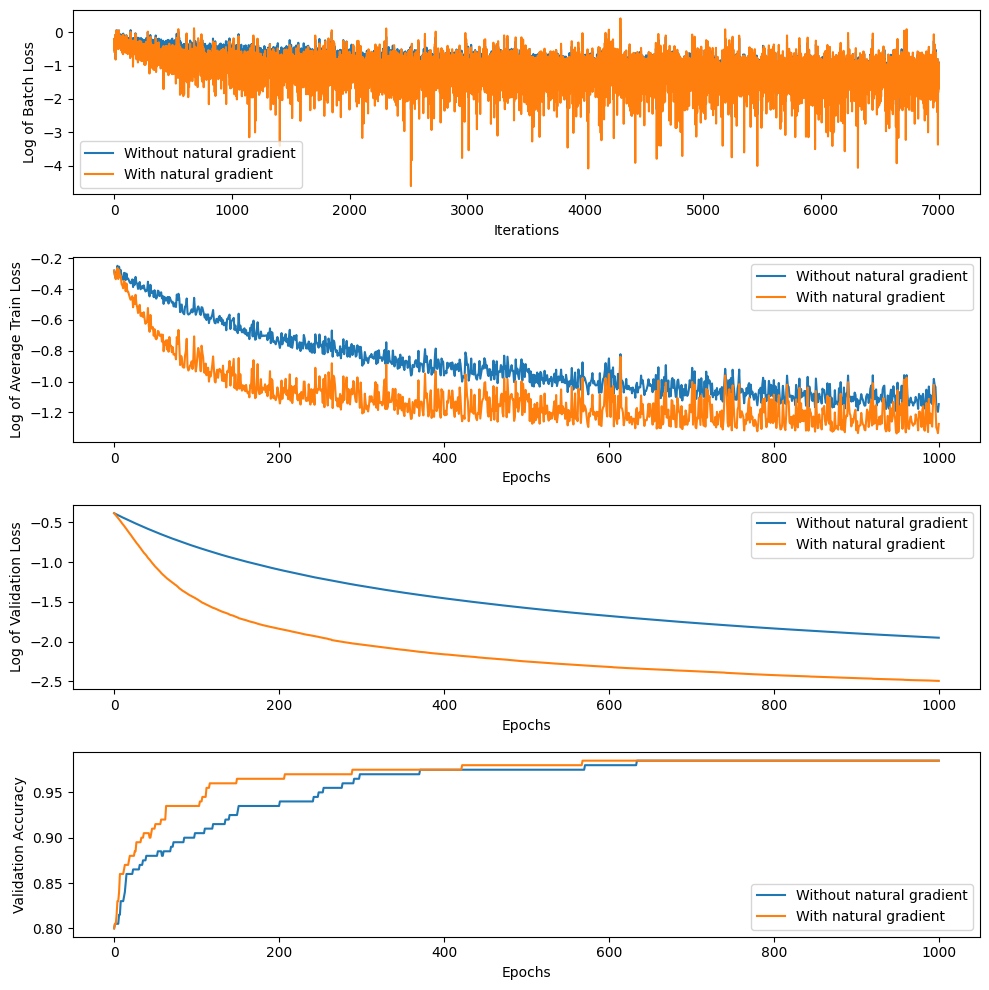

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(4,1,1)
plt.plot(grad_descent_train_info['iter_wise']['iterations'], np.log(grad_descent_train_info['iter_wise']['loss']), label = 'Without natural gradient')
plt.plot(natural_grad_descent_train_info['iter_wise']['iterations'], np.log(natural_grad_descent_train_info['iter_wise']['loss']), label = 'With natural gradient')
plt.xlabel("Iterations")
plt.ylabel("Log of Batch Loss")
plt.legend()
plt.subplot(4,1,2)
plt.plot(grad_descent_train_info['epoch_wise']['epochs'], np.log(grad_descent_train_info['epoch_wise']['loss']), label = 'Without natural gradient')
plt.plot(natural_grad_descent_train_info['epoch_wise']['epochs'], np.log(natural_grad_descent_train_info['epoch_wise']['loss']), label = 'With natural gradient')
plt.xlabel("Epochs")
plt.ylabel("Log of Average Train Loss")
plt.legend()
plt.subplot(4,1,3)
plt.plot(grad_descent_train_info['epoch_wise']['epochs'], np.log(grad_descent_train_info['epoch_wise']['val_loss']), label = 'Without natural gradient')
plt.plot(natural_grad_descent_train_info['epoch_wise']['epochs'], np.log(natural_grad_descent_train_info['epoch_wise']['val_loss']), label = 'With natural gradient')
plt.xlabel("Epochs")
plt.ylabel("Log of Validation Loss")
plt.legend()
plt.subplot(4,1,4)
plt.plot(grad_descent_train_info['epoch_wise']['epochs'], grad_descent_train_info['epoch_wise']['val_accuracy'], label = 'Without natural gradient')
plt.plot(natural_grad_descent_train_info['epoch_wise']['epochs'], natural_grad_descent_train_info['epoch_wise']['val_accuracy'], label = 'With natural gradient')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.tight_layout()